<a href="https://colab.research.google.com/github/mirovix/CV_final_project/blob/main/NN_boats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import json
import io
from google.colab import drive
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

In [47]:
drive.mount('/content/drive')

with open('/content/drive/MyDrive/dataset_boats/label.json') as json_file:
    json_file = json.load(json_file)

#print(len(json_file[30]['Label']))

x_start, y_start, x_end, y_end = [],[],[],[]
data,targets = [],[]
width = 32
height = 32

for row in json_file:

  if(len(row['Label']) == 0):
    continue

  x_start = float(row['Label']['objects'][0]['bbox']['left'])
  y_start = float(row['Label']['objects'][0]['bbox']['top'])
  x_end = float(row['Label']['objects'][0]['bbox']['left'] + row['Label']['objects'][0]['bbox']['width'])
  y_end = float(row['Label']['objects'][0]['bbox']['top'] + row['Label']['objects'][0]['bbox']['height'])
  
  image_path = "/content/drive/MyDrive/dataset_boats/train/" + row['External ID']
  cv_image = cv2.imread(image_path)

  x_start = (width * x_start) / cv_image.shape[1]
  y_start = (height * y_start) / cv_image.shape[0]
  x_end = (width * x_end) / cv_image.shape[1]
  y_end = (height * y_end) / cv_image.shape[0]
  targets.append((x_start, y_start, x_end, y_end))

  cv_image = cv2.resize(cv_image, (height, width))
  data.append(img_to_array(cv_image))
  


print(len(data))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
853


In [48]:
print(cv_image.shape[0])
print(cv_image.shape[1])


32
32


In [49]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
#data = np.array(data, dtype="float32") / 255.0
#targets = np.array(targets, dtype="float32")
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
data = np.array(data, dtype="float32") / 255
targets = np.array(targets, dtype="float32") / 255

X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.15)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25) # 0.25 x (1 - 0.15) = 0.2125

In [50]:
mean = np.mean(X_train, axis = 0)
std = np.std(X_train, axis = 0)

X_train = (X_train - mean) /  std
X_val = (X_val - mean) /  std
X_test = (X_test - mean) /  std

In [51]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 30, 30, 256)       7168      
_________________________________________________________________
batch_normalization_64 (Batc (None, 30, 30, 256)       1024      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 14, 14, 128)       131200    
_________________________________________________________________
batch_normalization_65 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 6, 6, 64)        

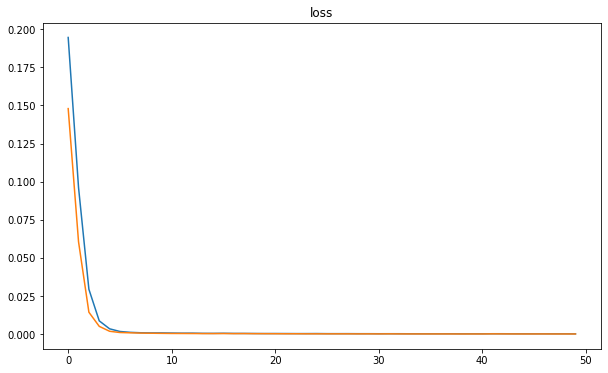

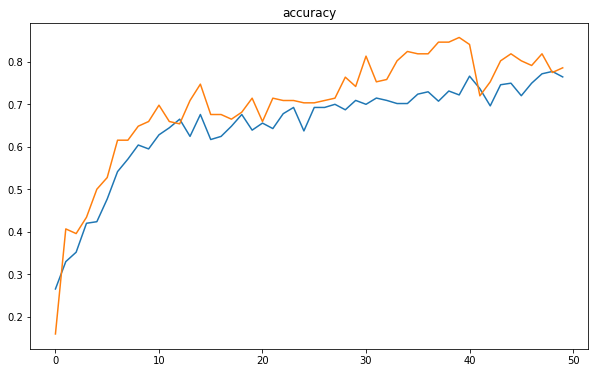

In [52]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=256, kernel_size=[3,3], activation='relu', input_shape=[height, width, 3]),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Conv2D(filters=128, kernel_size=[2,2], activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Conv2D(filters=64, kernel_size=[2,2], activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Conv2D(filters=32, kernel_size=[2,2], activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=16, kernel_size=[2,2], activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(4, activation="sigmoid")
  ])

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
  
print(model.summary())

history = model.fit(X_train, y_train, epochs=50, batch_size=4 ,validation_data=(X_val, y_val))

plot_loss(history)
plot_accuracy(history)

scores = model.evaluate(X_test, y_test, verbose=2)
print(" %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("----------------------------")